In [1]:
# From source: https://keras.io/examples/keras_recipes/reproducibility_recipes/
import tensorflow as tf
import numpy as np

# Then Set Random Seeds
tf.keras.utils.set_random_seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Then run the Enable Deterministic Operations Function
tf.config.experimental.enable_op_determinism()

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler

## Load the Data

In [3]:
# Adding different sub folder
import sys
import os

# Append the path to the Data folder
data_folder_path = os.path.abspath('Data')
sys.path.append(data_folder_path)

## Load the autoreload extension
%load_ext autoreload
%autoreload 2

try:
    import Custom_Functions as fn
    print("Custom_Functions module imported successfully!")
except ModuleNotFoundError:
    print(f"Failed to import Custom_Functions module from {data_folder_path}")

Custom_Functions module imported successfully!


In [4]:
# Load Data from your path
df = pd.read_csv("Data/spooky.csv", index_col = 'id')
df.head()

,text,author
id,,
id26305,"This process, however, afforded me no means of...",EAP
id17569,It never once occurred to me that the fumbling...,HPL
id11008,"In his left hand was a gold snuff box, from wh...",EAP
id27763,How lovely is spring As we looked from Windsor...,MWS
id12958,"Finding nothing else, not even gold, the Super...",HPL


In [5]:
# We will split on each space, and then get the length
df['sequence_length'] =df['text'].map( lambda x: len(x.split(" ")))
df.head()

,text,author,sequence_length
id,,,
id26305,"This process, however, afforded me no means of...",EAP,41
id17569,It never once occurred to me that the fumbling...,HPL,14
id11008,"In his left hand was a gold snuff box, from wh...",EAP,36
id27763,How lovely is spring As we looked from Windsor...,MWS,34
id12958,"Finding nothing else, not even gold, the Super...",HPL,27


In [6]:
df['sequence_length'].describe()

count    19579.000000
mean        26.730477
std         19.048353
min          2.000000
25%         15.000000
50%         23.000000
75%         34.000000
max        861.000000
Name: sequence_length, dtype: float64

The range of sequence lengths is from 2 to 861
The average sequence length is 26.73

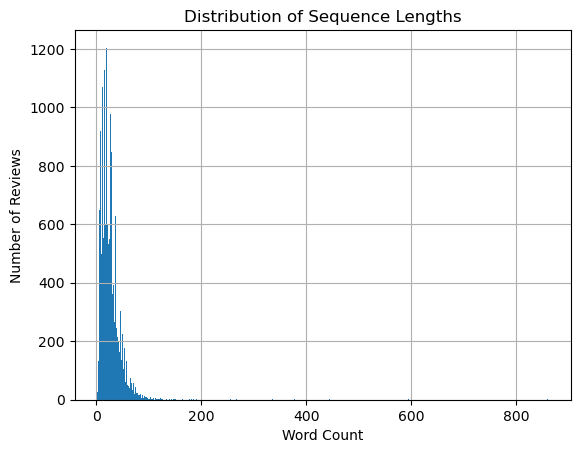

In [7]:
# Make histogram of sequence lengths
ax = df['sequence_length'].hist(bins = 'auto')
ax.set_xlabel('Word Count')
ax.set_ylabel('Number of Reviews')
ax.set_title('Distribution of Sequence Lengths');

In [8]:
df['author'].value_counts(normalize = True)

EAP    0.403494
MWS    0.308698
HPL    0.287808
Name: author, dtype: float64

In [9]:
# Use RUS to reduce n to match minority group
sampler = RandomUnderSampler(random_state=42)
df,  _ = sampler.fit_resample(df, df['author'])
df['author'].value_counts()

EAP    5635
HPL    5635
MWS    5635
Name: author, dtype: int64

In [10]:
# Crate a map for targets
target_map = {'EAP':0,
             'HPL':1,
             'MWS':2}
y = df['author'].map(target_map)
y

id
id22483    0
id18809    0
id16322    0
id13423    0
id09553    0
          ..
id22356    2
id11504    2
id00149    2
id16796    2
id23776    2
Name: author, Length: 16905, dtype: int64

In [11]:
# X and y
X = df['text'].values
X

array(['He then asked me, suddenly, if I had observed any thing peculiar at the scene of the atrocity.',
       'Through the exertions of Beauvais, the matter was industriously hushed up, as far as possible; and several days had elapsed before any public emotion resulted.',
       'The cold was intense, and obliged me to wrap up closely in an overcoat.',
       ...,
       'What I ask of you is reasonable and moderate; I demand a creature of another sex, but as hideous as myself; the gratification is small, but it is all that I can receive, and it shall content me.',
       'The birth of her daughter, embryo copy of her Raymond, filled up the measure of her content, and produced a sacred and indissoluble tie between them.',
       "I heard my sister's sobs, and thought, happy are women who can weep, and in a passionate caress disburthen the oppression of their feelings; shame and habitual restraint hold back a man."],
      dtype=object)

In [12]:
y.value_counts(normalize = True)

0    0.333333
1    0.333333
2    0.333333
Name: author, dtype: float64

In [13]:
classes = y.unique()
classes

array([0, 1, 2], dtype=int64)

In [14]:
# Convert to Dataset Object
ds = tf.data.Dataset.from_tensor_slices((X, y))

# Shuffle dataset
ds = ds.shuffle(buffer_size=len(ds),reshuffle_each_iteration=False) 

In [15]:
# Set the ratio of the train, validation, test split
split_train = .7
split_val =  .2
split_test =  1 -( split_train + split_val )

# Calculate the number of samples for training and validation data 
n_train_samples =  int(len(ds) * split_train)
n_val_samples = int(len(ds) * split_val)
n_test_samples = len(ds) -(n_train_samples + n_val_samples)

# Set the batch size
BATCH_SIZE =32


import math
# math.ceil will round up
# How many batches? 
n_train_batches = math.ceil(n_train_samples/BATCH_SIZE)
n_val_batches = math.ceil(n_val_samples/BATCH_SIZE)
n_test_batches = math.ceil(n_test_samples/BATCH_SIZE)

print(f"    - train:\t{n_train_samples} samples \t({n_train_batches} batches)")
print(f"    - val:  \t{n_val_samples} samples \t({n_val_batches} batches)")
print(f"    - test: \t{n_test_samples} samples \t({n_test_batches} batches)")

    - train:	11833 samples 	(370 batches)
    - val:  	3381 samples 	(106 batches)
    - test: 	1691 samples 	(53 batches)


In [16]:
# Use take and skip to define each set
train_ds = ds.take(n_train_samples).batch(batch_size=BATCH_SIZE)

# Skip over the training batches and take the validation batches
val_ds = ds.skip(n_train_samples).take(n_val_samples).batch(batch_size=BATCH_SIZE)

# Skipver the train and validation batches, the remaining are the test batches
test_ds = ds.skip(n_train_samples + n_val_samples).batch(batch_size=BATCH_SIZE)

In [17]:
# Confirm the number of batches in each
print (f' There are {len(train_ds)} training batches.')
print (f' There are {len(val_ds)} validation batches.')
print (f' There are {len(test_ds)} testing batches.')

 There are 370 training batches.
 There are 106 validation batches.
 There are 53 testing batches.


## Text Vectorization

In [18]:
SEQUENCE_LENGTH = 100
# Create text Vectorization layer
sequence_vectorizer = tf.keras.layers.TextVectorization(
    standardize="lower_and_strip_punctuation",
    output_mode="int",
    output_sequence_length=SEQUENCE_LENGTH
)

In [19]:
# Get just the text from ds_train
ds_texts = train_ds.map(lambda x, y: x)

# Preview the text
ds_texts.take(1).get_single_element()

<tf.Tensor: shape=(32,), dtype=string, numpy=
array([b'And this was in truth the Death of which these bystanders spoke reverently, in low whispers you, sweet Una, gaspingly, with loud cries.',
       b'Had my eyes deceived me?',
       b"For some distance the line kept on along the gorge's brink, but at length I reached the long covered bridge where it crossed the chasm at a dizzy height.",
       b'The two forces mingling, unarmed and hand in hand, talking only how each might assist the other, the adversaries conjoined; each repenting, the one side their former cruelties, the other their late violence, they obeyed the orders of the General to proceed towards London.',
       b'I have already put off the carelessness of childhood, the unlined brow, and springy gait of early years, that they may adorn thee.',
       b'Idleness had ever been irksome to me, and now that I wished to fly from reflection, and hated my former studies, I felt great relief in being the fellow pupil with my frie

In [20]:
# Train (adapt on training text data))
sequence_vectorizer.adapt(ds_texts)
sequence_vectorizer.vocabulary_size()

20976

In [21]:
# Programmatically define size of vocab from vectorization layer
VOCAB_SIZE = sequence_vectorizer.vocabulary_size()
VOCAB_SIZE

20976

In [22]:
# Getting list of vocab
vocab = sequence_vectorizer.get_vocabulary()
int_to_str = {idx: word for idx, word in enumerate(vocab)}
int_to_str

{0: '',
 1: '[UNK]',
 2: 'the',
 3: 'of',
 4: 'and',
 5: 'to',
 6: 'i',
 7: 'a',
 8: 'in',
 9: 'was',
 10: 'that',
 11: 'my',
 12: 'it',
 13: 'he',
 14: 'had',
 15: 'with',
 16: 'his',
 17: 'as',
 18: 'for',
 19: 'but',
 20: 'which',
 21: 'not',
 22: 'me',
 23: 'at',
 24: 'from',
 25: 'by',
 26: 'on',
 27: 'this',
 28: 'is',
 29: 'her',
 30: 'be',
 31: 'were',
 32: 'have',
 33: 'you',
 34: 'all',
 35: 'an',
 36: 'we',
 37: 'or',
 38: 'no',
 39: 'when',
 40: 'him',
 41: 'one',
 42: 'so',
 43: 'they',
 44: 'been',
 45: 'could',
 46: 'would',
 47: 'she',
 48: 'there',
 49: 'upon',
 50: 'more',
 51: 'its',
 52: 'their',
 53: 'now',
 54: 'what',
 55: 'some',
 56: 'our',
 57: 'into',
 58: 'if',
 59: 'them',
 60: 'who',
 61: 'are',
 62: 'will',
 63: 'than',
 64: 'then',
 65: 'only',
 66: 'very',
 67: 'up',
 68: 'before',
 69: 'man',
 70: 'about',
 71: 'even',
 72: 'these',
 73: 'out',
 74: 'yet',
 75: 'your',
 76: 'time',
 77: 'did',
 78: 'any',
 79: 'old',
 80: 'said',
 81: 'might',
 82: 'li

In [23]:
# What term corresponds to 1000?
int_to_str[1000]

'occasion'

In [24]:
# Obtain the sequence of sample text with the sequence_vectorizer
sequence= sequence_vectorizer(['Text Vectorization is an essential tool for converting text into a format that machine learning models can use.'])
sequence

<tf.Tensor: shape=(1, 100), dtype=int64, numpy=
array([[ 6345,     1,    28,    35,  6996, 13401,    18,     1,  6345,
           57,     7,     1,    10,   833,  3862, 16160,   122,   521,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,
            0]], dtype=int64)>

# Text Classification with RNNs

In [25]:
%load_ext autoreload
%autoreload 2

import Custom_Functions as fn

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [26]:
from tensorflow.keras.layers import Embedding
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, optimizers, regularizers

In [27]:
# defining embed_dim
EMBED_DIM = 150
# Confirm these values
print(f' VOCAB_SIZE: {VOCAB_SIZE}')
print(f' EMBED_DIM: {EMBED_DIM}')
print(f' SEQUENCE_LENGTH: {SEQUENCE_LENGTH}')

 VOCAB_SIZE: 20976
 EMBED_DIM: 150
 SEQUENCE_LENGTH: 100


## Base Model GRU

In [28]:
def build_gru_model(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    gru_model = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=150, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    ## Add an GRU layer with 128 units
    gru_model.add(layers.GRU(128))
    
    # Add output layer
    gru_model.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    gru_model.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    gru_model.summary()
    return gru_model

In [30]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_1 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru_1 (GRU)                 (None, 128)               107520    
                                                                 
 dense_1 (Dense)             (None, 3)                 387       
                                                                 
Total params: 3,254,307
Trainable params: 3,254,307
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
370/370 [==============================] - 34s 86ms/step - loss: 1.1254 - accuracy: 0.3697 - val_lo

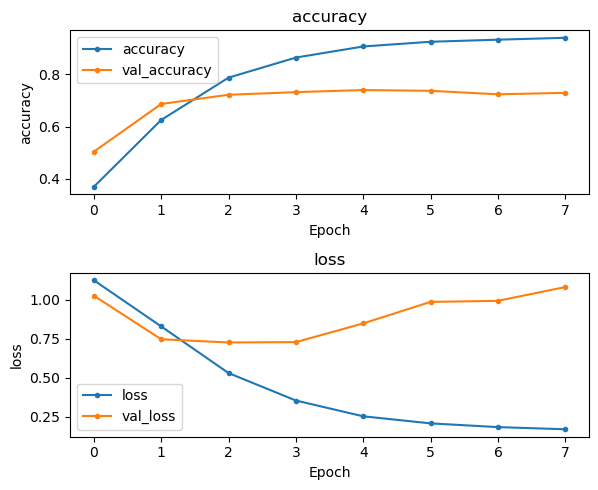

In [31]:
# Build the lstm model and specify the vectorizer
gru_model = build_gru_model(sequence_vectorizer)

# Defien number of epocs
EPOCHS = 30
# Fit the model
history = gru_model.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)
fn.plot_history(history, figsize=(6,5))


- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3906
           1       1.00      0.92      0.96      3952
           2       0.96      0.96      0.96      3975

    accuracy                           0.96     11833
   macro avg       0.96      0.96      0.96     11833
weighted avg       0.96      0.96      0.96     11833



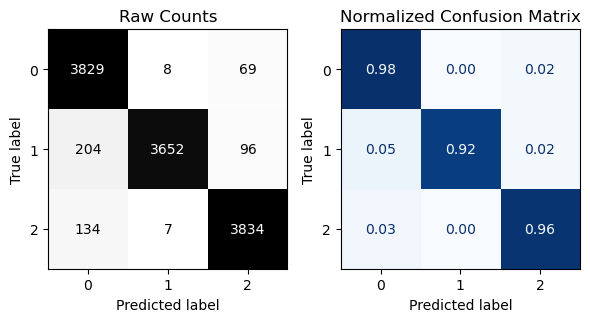


- Evaluating Training Data:
370/370 [==============================] - 6s 17ms/step - loss: 0.1243 - accuracy: 0.9562
{'loss': 0.12429984658956528, 'accuracy': 0.9562241435050964}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       559
           1       0.80      0.62      0.70       560
           2       0.71      0.73      0.72       572

    accuracy                           0.70      1691
   macro avg       0.71      0.70      0.70      1691
weighted avg       0.71      0.70      0.70      1691



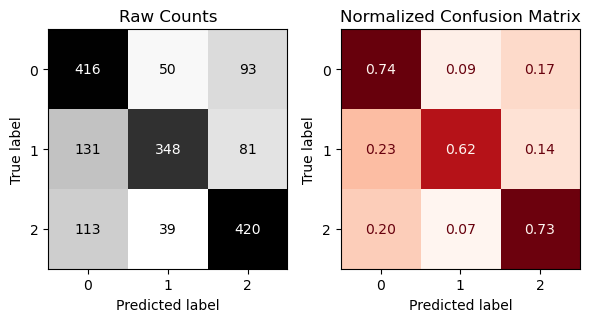


- Evaluating Test Data:
53/53 [==============================] - 1s 17ms/step - loss: 1.2527 - accuracy: 0.7002
{'loss': 1.252732276916504, 'accuracy': 0.7001774311065674}


In [32]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model, X_train=train_ds, 
    X_test=test_ds,# history=history
);

## Model 1 Stacked GRU

In [33]:
def build_gru_model2(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    gru_model2 = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    ## Add an GRU layer with 128 units
    gru_model2.add(layers.GRU(128, return_sequences=True))
    gru_model2.add(layers.Dropout(.5))
    gru_model2.add(layers.GRU(64, return_sequences=True))
    gru_model2.add(layers.GlobalMaxPooling1D())
    # Add output layer
    gru_model2.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    gru_model2.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    gru_model2.summary()
    return gru_model2

In [34]:
# Include callbacks
def get_callbacks(patience=3, monitor='val_accuracy'):
    early_stop = tf.keras.callbacks.EarlyStopping(patience=patience, monitor=monitor)
    return [early_stop]

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_2 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru_2 (GRU)                 (None, 100, 128)          107520    
                                                                 
 dropout (Dropout)           (None, 100, 128)          0         
                                                                 
 gru_3 (GRU)                 (None, 100, 64)           37248     
                                                                 
 global_max_pooling1d (Globa  (None, 64)               0         
 lMaxPooling1D)                                       

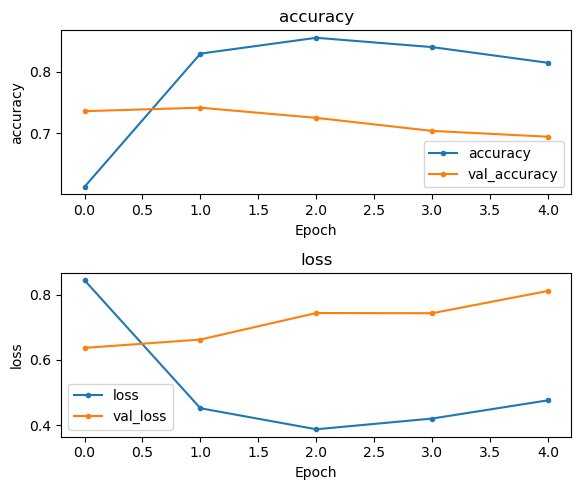

In [35]:
# Build model
gru_model2 = build_gru_model2(sequence_vectorizer)

EPOCHS = 30
history =  gru_model2.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

fn.plot_history(history,figsize=(6,5))




- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.78      0.83      0.81      3906
           1       0.88      0.85      0.86      3952
           2       0.84      0.81      0.82      3975

    accuracy                           0.83     11833
   macro avg       0.83      0.83      0.83     11833
weighted avg       0.83      0.83      0.83     11833



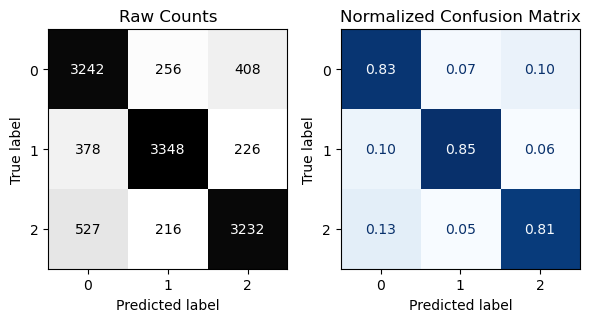


- Evaluating Training Data:
370/370 [==============================] - 10s 26ms/step - loss: 0.4342 - accuracy: 0.8301
{'loss': 0.43423599004745483, 'accuracy': 0.8300515413284302}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.64      0.70      0.67       559
           1       0.75      0.70      0.73       560
           2       0.70      0.67      0.69       572

    accuracy                           0.69      1691
   macro avg       0.70      0.69      0.69      1691
weighted avg       0.70      0.69      0.69      1691



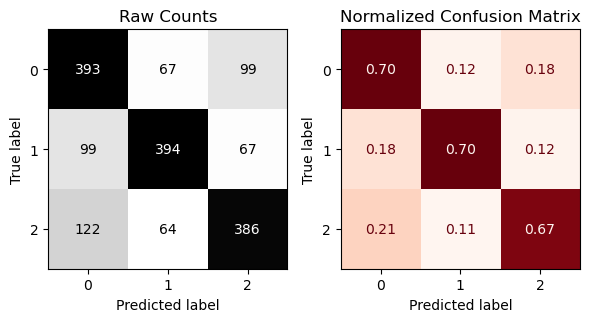


- Evaluating Test Data:
53/53 [==============================] - 1s 26ms/step - loss: 0.8480 - accuracy: 0.6937
{'loss': 0.8479853272438049, 'accuracy': 0.6936723589897156}


In [36]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model2, X_train=train_ds, 
    X_test=test_ds,# history=history
);

Will add an LSTM layer to the model

## Model 2 Hybrid Stacked GRU

In [37]:
def build_gru_model3(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    gru_model3 = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    ## Add an GRU layer with 128 units
    gru_model3.add(layers.GRU(128, return_sequences=True))
    gru_model3.add(layers.Dropout(.5))
    ## Add an LSTM layer with 128 units
    gru_model3.add(layers.LSTM(128, return_sequences=True))
    gru_model3.add(layers.GlobalMaxPooling1D())
    # Add output layer
    gru_model3.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    gru_model3.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    gru_model3.summary()
    return gru_model3

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_3 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 gru_4 (GRU)                 (None, 100, 128)          107520    
                                                                 
 dropout_1 (Dropout)         (None, 100, 128)          0         
                                                                 
 lstm (LSTM)                 (None, 100, 128)          131584    
                                                                 
 global_max_pooling1d_1 (Glo  (None, 128)              0         
 balMaxPooling1D)                                     

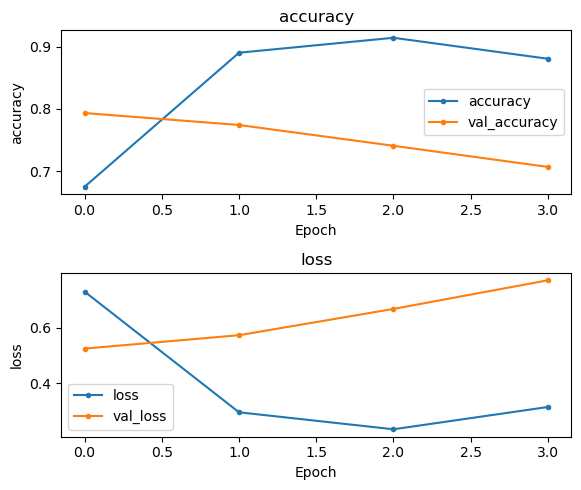

In [38]:
# Build model
gru_model3 = build_gru_model3(sequence_vectorizer)

EPOCHS = 30
history =  gru_model3.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

fn.plot_history(history,figsize=(6,5))




- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.86      0.89      0.87      3906
           1       0.89      0.90      0.89      3952
           2       0.89      0.87      0.88      3975

    accuracy                           0.88     11833
   macro avg       0.88      0.88      0.88     11833
weighted avg       0.88      0.88      0.88     11833



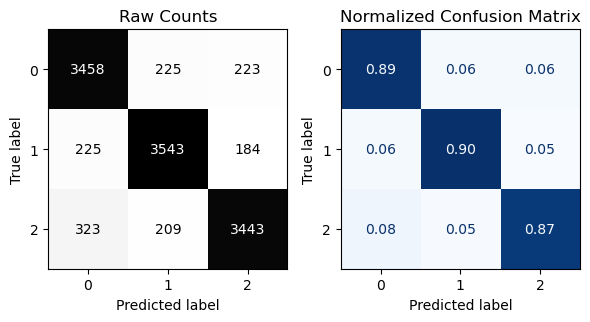


- Evaluating Training Data:
370/370 [==============================] - 14s 39ms/step - loss: 0.3080 - accuracy: 0.8826
{'loss': 0.3079775869846344, 'accuracy': 0.882616400718689}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.69      0.71      0.70       559
           1       0.74      0.71      0.73       560
           2       0.74      0.74      0.74       572

    accuracy                           0.72      1691
   macro avg       0.72      0.72      0.72      1691
weighted avg       0.72      0.72      0.72      1691



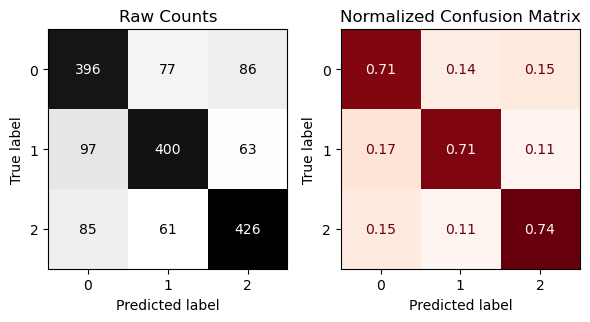


- Evaluating Test Data:
53/53 [==============================] - 2s 38ms/step - loss: 0.7098 - accuracy: 0.7226
{'loss': 0.7097565531730652, 'accuracy': 0.722649335861206}


In [39]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model3, X_train=train_ds, 
    X_test=test_ds,# history=history
);

Adding the additional drop out layer and LSTM decreased the accuracY I will remove and instead use a bidirectional layer

## Model 3 Bi-Directional Stacked GRU

In [42]:
def build_gru_model4(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    gru_model4 = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    ## Add an GRU layer with 128 units
    gru_model4.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
    gru_model4.add(layers.GRU(64, return_sequences=True))
    gru_model4.add(layers.GlobalMaxPooling1D())
    # Add output layer
    gru_model4.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    gru_model4.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    gru_model4.summary()
    return gru_model4

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_5 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 bidirectional_1 (Bidirectio  (None, 100, 256)         215040    
 nal)                                                            
                                                                 
 gru_7 (GRU)                 (None, 100, 64)           61824     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                      

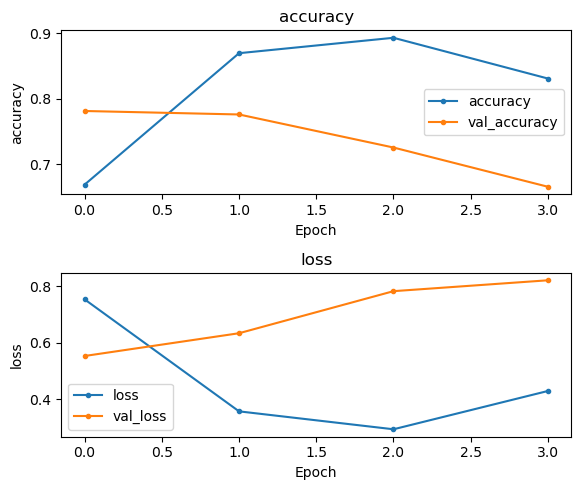

In [43]:
# Build model
gru_model4 = build_gru_model4(sequence_vectorizer)

EPOCHS = 30
history =  gru_model4.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

fn.plot_history(history,figsize=(6,5))




- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.76      0.83      0.79      3906
           1       0.85      0.81      0.83      3952
           2       0.85      0.81      0.83      3975

    accuracy                           0.82     11833
   macro avg       0.82      0.82      0.82     11833
weighted avg       0.82      0.82      0.82     11833



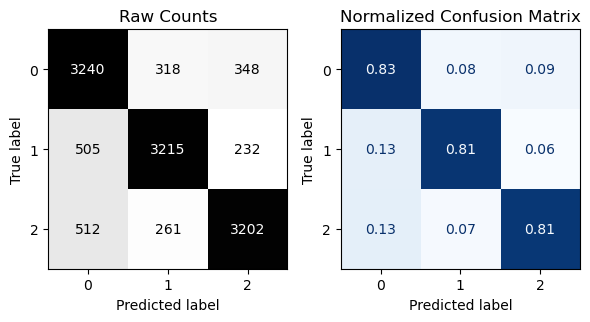


- Evaluating Training Data:
370/370 [==============================] - 14s 37ms/step - loss: 0.4606 - accuracy: 0.8161
{'loss': 0.4605911672115326, 'accuracy': 0.8161075115203857}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.59      0.73      0.65       559
           1       0.71      0.60      0.65       560
           2       0.73      0.66      0.69       572

    accuracy                           0.67      1691
   macro avg       0.68      0.67      0.67      1691
weighted avg       0.68      0.67      0.67      1691



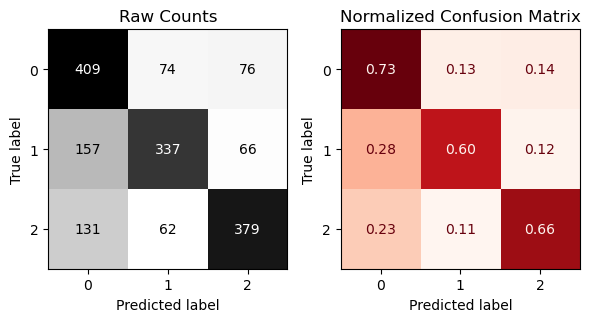


- Evaluating Test Data:
53/53 [==============================] - 2s 37ms/step - loss: 0.8282 - accuracy: 0.6653
{'loss': 0.8281534314155579, 'accuracy': 0.6652868390083313}


In [44]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model4, X_train=train_ds, 
    X_test=test_ds,# history=history
);

## Model 4 Bi-Directional Simpler GRU

In [45]:
def build_gru_model5(text_vectorization_layer):
    # Getting Text Parameters from TextVectorization Layer
    VOCAB_SIZE = text_vectorization_layer.vocabulary_size()
    SEQUENCE_LENGTH = text_vectorization_layer.get_config()['output_sequence_length']
    
    
    # Define sequential model with pre-trained vectorization layer and *new* embedding layer
    gru_model5 = Sequential([
        text_vectorization_layer,
        layers.Embedding(input_dim=VOCAB_SIZE,
                                  output_dim=EMBED_DIM, 
                                  input_length=SEQUENCE_LENGTH)
        ])
        
    ## Add an GRU layer with 128 units
    gru_model5.add(layers.Bidirectional(layers.GRU(128, return_sequences=True)))
    gru_model5.add(layers.GlobalMaxPooling1D())
   
    # Add output layer
    gru_model5.add(layers.Dense(len(classes), activation='softmax'))
 
    # Compile the model
    gru_model5.compile(optimizer=optimizers.legacy.Adam(learning_rate = .01), 
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    
    gru_model5.summary()
    return gru_model5

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 100)              0         
 torization)                                                     
                                                                 
 embedding_6 (Embedding)     (None, 100, 150)          3146400   
                                                                 
 bidirectional_2 (Bidirectio  (None, 100, 256)         215040    
 nal)                                                            
                                                                 
 gru_9 (GRU)                 (None, 100, 64)           61824     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                      

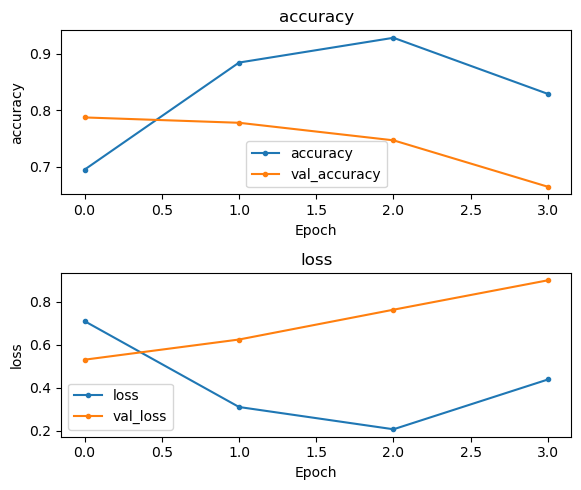

In [46]:
# Build model
gru_model5 = build_gru_model5(sequence_vectorizer)

EPOCHS = 30
history =  gru_model5.fit(
    train_ds,
    epochs=EPOCHS,
    validation_data=val_ds,
    callbacks=get_callbacks(),
)

fn.plot_history(history,figsize=(6,5))




- Evaluating Network...
----------------------------------------------------------------------
 Classification Metrics: Training Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.91      0.70      0.79      3906
           1       0.79      0.87      0.83      3952
           2       0.80      0.89      0.84      3975

    accuracy                           0.82     11833
   macro avg       0.83      0.82      0.82     11833
weighted avg       0.83      0.82      0.82     11833



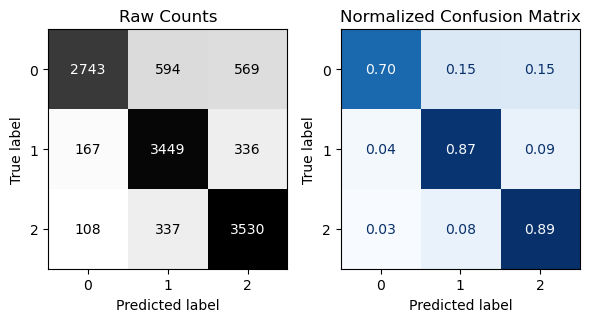


- Evaluating Training Data:
370/370 [==============================] - 14s 38ms/step - loss: 0.4594 - accuracy: 0.8216
{'loss': 0.45944708585739136, 'accuracy': 0.821600615978241}
----------------------------------------------------------------------
 Classification Metrics: Test Data
----------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.71      0.50      0.59       559
           1       0.64      0.72      0.68       560
           2       0.65      0.76      0.70       572

    accuracy                           0.66      1691
   macro avg       0.67      0.66      0.65      1691
weighted avg       0.67      0.66      0.65      1691



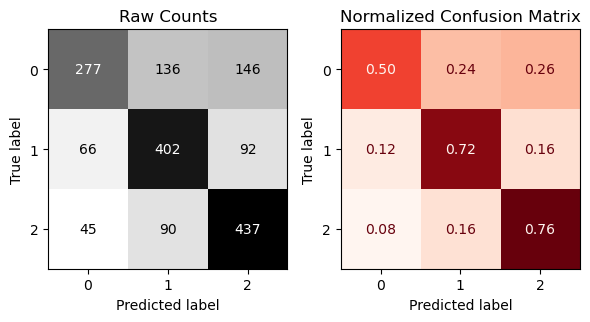


- Evaluating Test Data:
53/53 [==============================] - 2s 38ms/step - loss: 0.9067 - accuracy: 0.6600
{'loss': 0.9066864252090454, 'accuracy': 0.6599645018577576}


In [47]:
# Obtain the results
results = fn.evaluate_classification_network(
    gru_model5, X_train=train_ds, 
    X_test=test_ds,# history=history
);